## Intro
The goal of this notebook is use different machine learning algorithms to perform binary classification for phishing sites.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf

from matplotlib import pyplot

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

2024-07-24 14:11:33.122102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data preparation and Exploratory Data Analysis (EDA)
Using pandas, we read in the data in the CSV file

In [2]:
df = pd.read_csv('dataset_phishing.csv')
df

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,0,...,1,0,0,211,6728,0,0,1,0,phishing
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,0,...,0,0,0,2809,8515,8,0,1,10,legitimate
11428,http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,legitimate


We drop URL as it is unique for each row of data and is described by the other features.

In [3]:
df.drop(columns=['url'], inplace=True)

We check if any rows have missing data. If so, we have to deal with the missing data. However, there is no missing data in this dataset.

In [4]:
# Check for na values
df.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We can drop any features that have only one unique value as it would not have an effect on whether the link is phishing or not, so we end up dropping six features.

In [5]:
for c in df.columns:
    if len(df[c].unique()) == 1:
        df.drop(columns=[c], inplace=True)
        print(c)
len(df.columns)

nb_or
ratio_nullHyperlinks
ratio_intRedirection
ratio_intErrors
submit_email
sfh


82

We look at how many legitimate and phishing data points we have to see if there is an imbalance of each class. There is not an imbalance between legitimate and phishing classes as it is a 50/50 split.

In [6]:
df['status'].value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

We map legitimate to 0 and phishing to 1 for binary classification.

In [7]:
mapping = {'legitimate':0, 'phishing':1}

df['status'] = df['status'].map(mapping)

There are only numerical values for the features.

In [8]:
df.dtypes.to_numpy()

array([dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64

By looking at the correlation matrix, we can drop features that have low correlations with 'status'.

In [9]:
corr_matrix = df.corr(numeric_only=True)
target_corr = corr_matrix['status']
target_corr

length_url         0.248580
length_hostname    0.238322
ip                 0.321698
nb_dots            0.207029
nb_hyphens        -0.100107
                     ...   
web_traffic        0.060388
dns_record         0.122119
google_index       0.731171
page_rank         -0.511137
status             1.000000
Name: status, Length: 82, dtype: float64

We drop about 30 features and now have a total for 49 features.

In [10]:
threshold=0.1
drop_features = target_corr[abs(target_corr)<=threshold].index.tolist()
df.drop(columns=drop_features, inplace=True)
print(df.columns)
print(len(df.columns))

Index(['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at',
       'nb_qm', 'nb_and', 'nb_eq', 'nb_slash', 'nb_semicolumn', 'nb_www',
       'nb_com', 'https_token', 'ratio_digits_url', 'ratio_digits_host',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'shortening_service', 'length_words_raw',
       'shortest_word_host', 'longest_words_raw', 'longest_word_host',
       'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path',
       'phish_hints', 'suspecious_tld', 'statistical_report', 'nb_hyperlinks',
       'ratio_intHyperlinks', 'ratio_extRedirection', 'external_favicon',
       'links_in_tags', 'ratio_intMedia', 'ratio_extMedia', 'safe_anchor',
       'empty_title', 'domain_in_title', 'domain_with_copyright',
       'domain_registration_length', 'domain_age', 'dns_record',
       'google_index', 'page_rank', 'status'],
      dtype='object')
49


Standardization function for numerical features

In [11]:
def zscore_normalization(df, name):
    mean = df[name].mean()
    sd = df[name].std()

    df[name] = (df[name] - mean) / sd

For each feature, we can standardize the data. 
Standardizing data ensures that all features contribute equally to the model, improving performance, accuracy, and stability in machine learning algorithms.

In [12]:
for i in df.columns:
    if i != 'status':
        zscore_normalization(df, i)

We separate features and the target variable and split the data into train and test data.

In [13]:
X = df.drop(columns=['status'])
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

We create two dataframes to record the accuracy, f1 score, and times taken to train and test the models.

In [14]:
accuracies = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
times = pd.DataFrame(columns=["Model", "Train", "Test"])

Create a function to train, test, and cross-validate each model. It cross-validates the model using K-fold validation with 5 folds. It outputs the time taken to train and test the model, the accuracy and f1 score, the confusion matrix for binary classification, and the time taken to cross-validate the model.

In [15]:
def run_model(model_type, model, X_train, X_test, y_train, y_test, X, y):
    print(model_type, "classifier:") 
    
    start_time_train = time.time()  # Start time

    model.fit(X_train, y_train)  # Fit the classifier
    
    end_time_train = time.time()  # End time
    time_taken_train = end_time_train - start_time_train  # Time taken to run the code

    print(f"Time taken to train the {model_type} model: {time_taken_train} seconds")
    
    # Make predictions
    start_test = time.time()
    y_pred = model.predict(X_test)
    end_test = time.time()
    time_taken_test = end_test - start_test  # Time taken to run the code

    print(f"Time taken to test the {model_type} model: {time_taken_test} seconds")
    times.loc[len(times.index)] = [model_type,time_taken_train, time_taken_test]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", recall)
    print("F1 score:", f1)

    accuracies.loc[len(accuracies.index)] = [model_type, acc, prec, recall, f1]
    
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    #Cross validation 
    start_time_cv = time.time() 
    
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    end_time_cv = time.time()  # End time
    time_taken_cv = end_time_cv - start_time_cv  # Time taken to run the code

    print(f"Time taken to cross-validate the {model_type} model: {time_taken_cv} seconds")
    print("Cross-validation scores:", cv_scores)
    print("Mean CV accuracy:", cv_scores.mean())
    print("Standard deviation of CV accuracy:", cv_scores.std())

## Logistic Regression
We run, train, and cross-validate a Logistic Regression model. The model is trained quickly with an accuracy of 93.8%.

Logistic Regression classifier:
Time taken to train the Logistic Regression model: 0.07234382629394531 seconds
Time taken to test the Logistic Regression model: 0.002659320831298828 seconds
Accuracy: 0.9383202099737533
Precision: 0.9481090589270009
Recall: 0.9293103448275862
F1 score: 0.9386155855463648


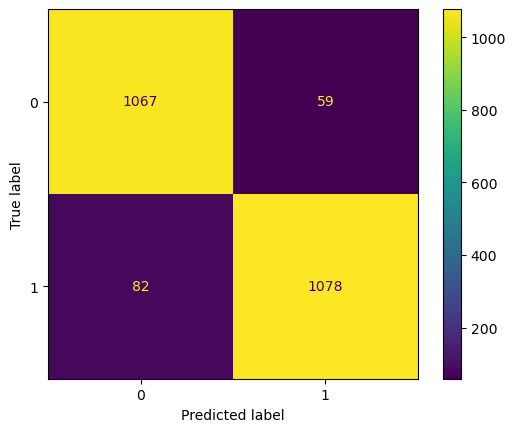

Time taken to cross-validate the Logistic Regression model: 0.22587227821350098 seconds
Cross-validation scores: [0.93963255 0.94619423 0.94356955 0.93875766 0.94225722]
Mean CV accuracy: 0.942082239720035
Standard deviation of CV accuracy: 0.002690911023487259


In [16]:
lr_model = LogisticRegression(random_state=0, max_iter=1000)
run_model('Logistic Regression', lr_model, X_train, X_test, y_train, y_test, X, y)

## Random Forest
We run, train, and cross-validate a Random Forest model. The model had an accuracy of 96.5%.

Random Forest classifier:
Time taken to train the Random Forest model: 1.4128139019012451 seconds
Time taken to test the Random Forest model: 0.03914785385131836 seconds
Accuracy: 0.9654418197725284
Precision: 0.9720524017467249
Recall: 0.9594827586206897
F1 score: 0.9657266811279827


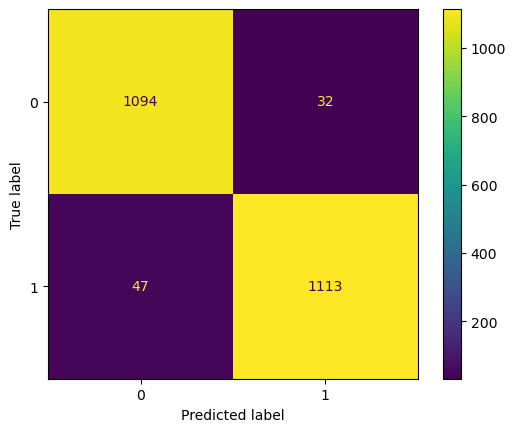

Time taken to cross-validate the Random Forest model: 7.31524920463562 seconds
Cross-validation scores: [0.9671916  0.96369204 0.96762905 0.96369204 0.96456693]
Mean CV accuracy: 0.9653543307086615
Standard deviation of CV accuracy: 0.001714428516383679


In [17]:
rf = RandomForestClassifier(random_state=0)
run_model('Random Forest', rf, X_train, X_test, y_train, y_test, X, y)

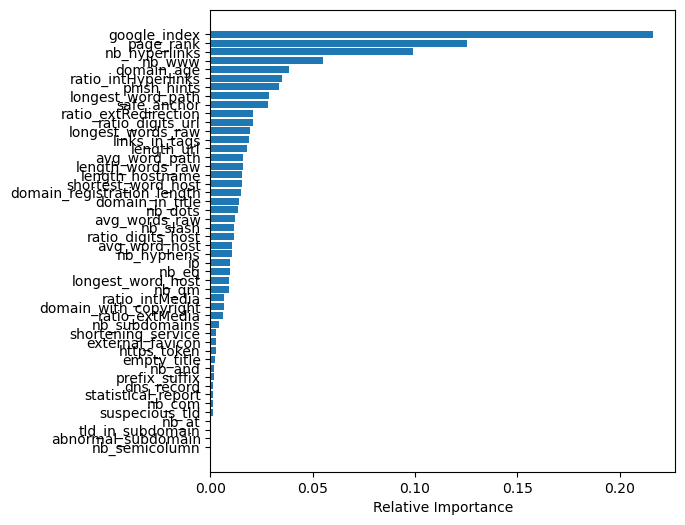

In [18]:
importances = (rf.feature_importances_)
i = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(i)), importances[i], align='center')
plt.yticks(range(len(i)), [df.columns[j] for j in i])
plt.xlabel('Relative Importance')
plt.show()

## Decision Tree
We run, train, and cross-validate a Decision Tree model. The model had an accuracy of 93.6%. From cross-validation, the Decision Tree produces similar accuracies for each fold.

Decision Tree classifier:
Time taken to train the Decision Tree model: 0.13449311256408691 seconds
Time taken to test the Decision Tree model: 0.0028333663940429688 seconds
Accuracy: 0.9356955380577427
Precision: 0.9400521285838401
Recall: 0.9327586206896552
F1 score: 0.9363911726525314


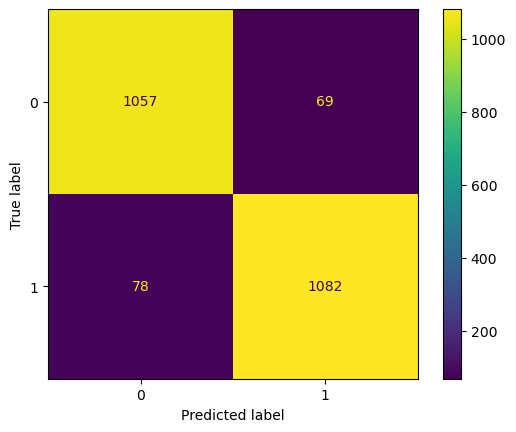

Time taken to cross-validate the Decision Tree model: 0.7145111560821533 seconds
Cross-validation scores: [0.94138233 0.93832021 0.93963255 0.93263342 0.93657043]
Mean CV accuracy: 0.9377077865266843
Standard deviation of CV accuracy: 0.0029874665055054893


In [19]:
dt = DecisionTreeClassifier(random_state=0)
run_model('Decision Tree', dt, X_train, X_test, y_train, y_test, X, y)

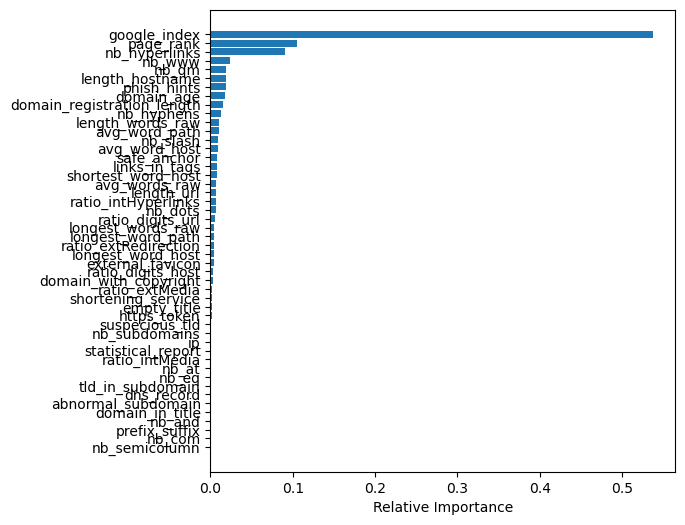

In [20]:
importances = (dt.feature_importances_)
i = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(i)), importances[i], align='center')
plt.yticks(range(len(i)), [df.columns[j] for j in i])
plt.xlabel('Relative Importance')
plt.show()

## Support Vector Machine
We run, train, and cross-validate a Support Vector Machine model. The model had an accuracy of 96.0%. The cross-validation took longer to run, but produces similar accuracies for each fold.

Support Vector Machine classifier:
Time taken to train the Support Vector Machine model: 1.2157666683197021 seconds
Time taken to test the Support Vector Machine model: 0.4290425777435303 seconds
Accuracy: 0.9606299212598425
Precision: 0.9636048526863085
Recall: 0.9586206896551724
F1 score: 0.9611063094209161


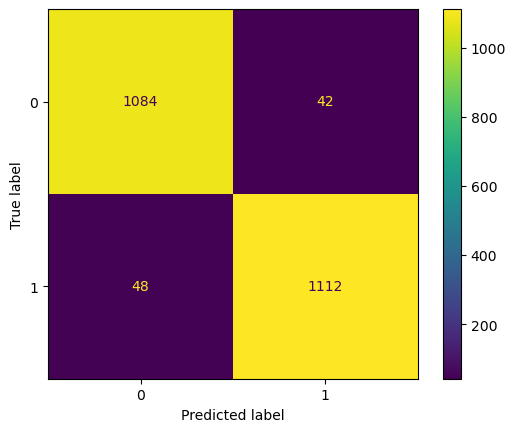

Time taken to cross-validate the Support Vector Machine model: 7.63017201423645 seconds
Cross-validation scores: [0.9575678  0.96150481 0.96369204 0.95800525 0.95975503]
Mean CV accuracy: 0.9601049868766405
Standard deviation of CV accuracy: 0.0022713482039802683


In [21]:
svc_model = SVC(random_state=0)
run_model('Support Vector Machine', svc_model, X_train, X_test, y_train, y_test, X, y)

## Gradient Boost
We run, train, and cross-validate a Gradient Boost model. The model was slower to train compared to the other models except SVM with an accuracy of 95.7%. 

Gradient Boost classifier:
Time taken to train the Gradient Boost model: 3.275540351867676 seconds
Time taken to test the Gradient Boost model: 0.007645368576049805 seconds
Accuracy: 0.9571303587051618
Precision: 0.9561855670103093
Recall: 0.9594827586206897
F1 score: 0.9578313253012049


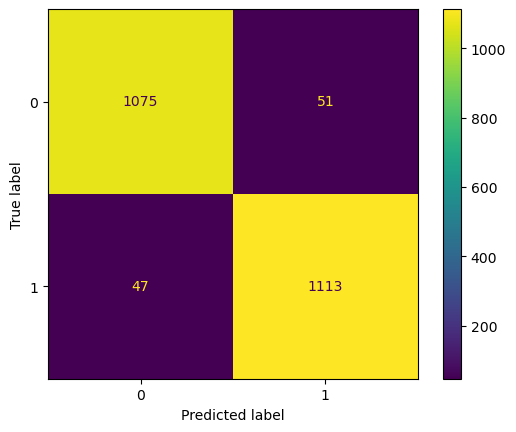

Time taken to cross-validate the Gradient Boost model: 16.226398944854736 seconds
Cross-validation scores: [0.95450569 0.95669291 0.96062992 0.95013123 0.95844269]
Mean CV accuracy: 0.9560804899387575
Standard deviation of CV accuracy: 0.003592382356543782


In [22]:
gbc = GradientBoostingClassifier()
run_model('Gradient Boost', gbc, X_train, X_test, y_train, y_test, X, y)

## Gaussian Naive Bayes
We run, train, and cross-validate a Gaussian Naive Bayes model. This model was the worst performing with an accuracy of 74.6%.

Gaussian Naive Bayes classifier:
Time taken to train the Gaussian Naive Bayes model: 0.00953984260559082 seconds
Time taken to test the Gaussian Naive Bayes model: 0.0035924911499023438 seconds
Accuracy: 0.7462817147856518
Precision: 0.9367469879518072
Recall: 0.5362068965517242
F1 score: 0.6820175438596491


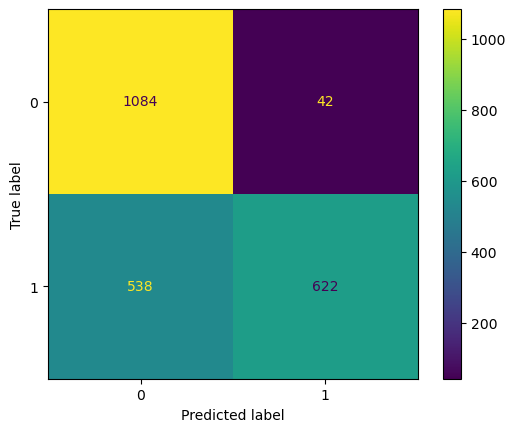

Time taken to cross-validate the Gaussian Naive Bayes model: 0.0887448787689209 seconds
Cross-validation scores: [0.75371829 0.74978128 0.75590551 0.7615923  0.75328084]
Mean CV accuracy: 0.7548556430446195
Standard deviation of CV accuracy: 0.003898911628198975


In [23]:
gnb = GaussianNB()
run_model('Gaussian Naive Bayes', gnb, X_train, X_test, y_train, y_test, X, y)

## Artificial Neural Network
We build an Artificial Neural Network with 1 input layer, 1 hidden layer with 64 units, and 1 output layer. We chose the 'relu' activation function for the hidden layers and use the adam optimizter and mean absolute error loss. We then train the model using batch size of 256 and 60 epochs. By implementing the early stopping optimization method, the model training will be stopped automatically when the model begins to overfit the data which is when the validation loss begins to increase. This happens at about 60 epochs, taking 11.05 seconds.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3136      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60


2024-07-24 14:12:16.422325: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


36/36 [==============================] - 1s 12ms/step - loss: 0.3256 - accuracy: 0.8015 - val_loss: 0.2304 - val_accuracy: 0.8972
Epoch 2/60
36/36 [==============================] - 0s 4ms/step - loss: 0.1966 - accuracy: 0.9218 - val_loss: 0.1793 - val_accuracy: 0.9243
Epoch 3/60
36/36 [==============================] - 0s 4ms/step - loss: 0.1611 - accuracy: 0.9371 - val_loss: 0.1596 - val_accuracy: 0.9322
Epoch 4/60
36/36 [==============================] - 0s 6ms/step - loss: 0.1435 - accuracy: 0.9405 - val_loss: 0.1473 - val_accuracy: 0.9335
Epoch 5/60
36/36 [==============================] - 0s 4ms/step - loss: 0.1325 - accuracy: 0.9412 - val_loss: 0.1420 - val_accuracy: 0.9339
Epoch 6/60
36/36 [==============================] - 0s 5ms/step - loss: 0.1242 - accuracy: 0.9415 - val_loss: 0.1348 - val_accuracy: 0.9335
Epoch 7/60
36/36 [==============================] - 0s 4ms/step - loss: 0.1184 - accuracy: 0.9429 - val_loss: 0.1322 - val_accuracy: 0.9335
Epoch 8/60
36/36 [============

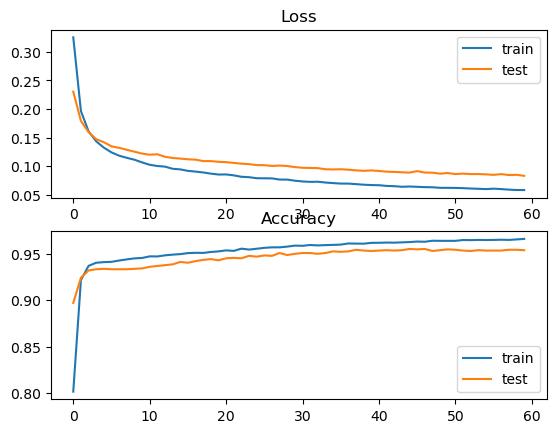

In [24]:
from keras import callbacks
input_shape = [X_train.shape[1]]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.build()

print(model.summary())
start_time_train = time.time()  # Start time

model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])  
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=256, epochs=60,callbacks=[earlystopping])
    
end_time_train = time.time()  # End time
time_taken_train = end_time_train - start_time_train  # Time taken to run the code

print(f"Time taken to train the Artificial Neural Network: {time_taken_train} seconds")
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
accuracy = history.history['accuracy'][11]

accuracies.loc[len(accuracies.index)] = ['ANN', accuracy, 0, 0, 0]
times.loc[len(times.index)] = ['ANN',time_taken_train, time_taken_train]

In [26]:
print(times)

                    Model      Train       Test
0     Logistic Regression   0.072344   0.002659
1           Random Forest   1.412814   0.039148
2           Decision Tree   0.134493   0.002833
3  Support Vector Machine   1.215767   0.429043
4          Gradient Boost   3.275540   0.007645
5    Gaussian Naive Bayes   0.009540   0.003592
6                     ANN  11.058213  11.058213


In [27]:
print(accuracies)

                    Model  Accuracy  Precision    Recall        F1
0     Logistic Regression  0.938320   0.948109  0.929310  0.938616
1           Random Forest  0.965442   0.972052  0.959483  0.965727
2           Decision Tree  0.935696   0.940052  0.932759  0.936391
3  Support Vector Machine  0.960630   0.963605  0.958621  0.961106
4          Gradient Boost  0.957130   0.956186  0.959483  0.957831
5    Gaussian Naive Bayes  0.746282   0.936747  0.536207  0.682018
6                     ANN  0.947288   0.000000  0.000000  0.000000
